In [1]:
# Import necessary libraries and modules
import nibabel as nib
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage as ndi
from skimage import measure
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as mcolors
from scipy.ndimage import map_coordinates
import meshplot as mp
import trimesh
import os

# Load Volume

In [2]:
# Load the brain volume data
brain_vol = nib.load('data/r_HEC_CON_001right.nii')

# Check the type of the brain volume object
print(type(brain_vol))

<class 'nibabel.nifti1.Nifti1Image'>


In [3]:
# Extract data from the brain volume object
brain_vol_data = brain_vol.get_fdata()
print(type(brain_vol_data))
print(brain_vol_data.shape)

<class 'numpy.memmap'>
(64, 64, 64)


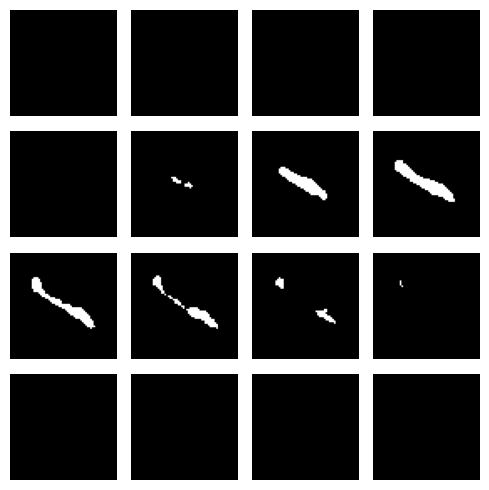

In [4]:
# Plot slices of the brain volume data using matplotlib
fig_rows, fig_cols = 4, 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[5, 5])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[img, :, :], 90), cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

# Mesh the volume

In [5]:
# Apply the marching cubes algorithm to extract surface mesh
verts, faces, normals, values = measure.marching_cubes(brain_vol_data, 0.5)

# Orient faces
faces = faces[:, ::-1]

In [6]:
# Plot the mesh
d = mp.subplot(verts, faces, s=[2, 2, 2])

# Smooth the mesh (laplacian filter)

In [7]:
# Load the mesh
mesh = trimesh.Trimesh(vertices=verts, faces=faces)

In [8]:
# Apply Loop subdivision
subdivided_mesh = mesh.subdivide_loop()

In [9]:
# Apply Laplacian smoothing
smoothed_mesh = trimesh.smoothing.filter_laplacian(subdivided_mesh, lamb=0.5, iterations=10, implicit_time_integration=False, volume_constraint=True, laplacian_operator=None)

In [10]:
# Now subdivided_mesh contains the vertices and faces of the subdivided mesh
# You can visualize it directly
# Plot the mesh
d = mp.subplot(smoothed_mesh.vertices, smoothed_mesh.faces.astype("int"), s=[2, 2, 2])

/Users/emmanueliarussi/miniconda3/envs/hypp/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(
/Users/emmanueliarussi/miniconda3/envs/hypp/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


# Load scalar field for texturing + Gaussian Smoothing

In [11]:
# Load a 3D scalar field to overlay onto the surface mesh
scalar_field = np.load('data/r_HEC_CON_001right.npy')

In [12]:
# Apply Gaussian smoothing
sigma = 1  # Standard deviation of the Gaussian kernel, adjust as needed
smoothed_scalar_field = scipy.ndimage.gaussian_filter(scalar_field, sigma)

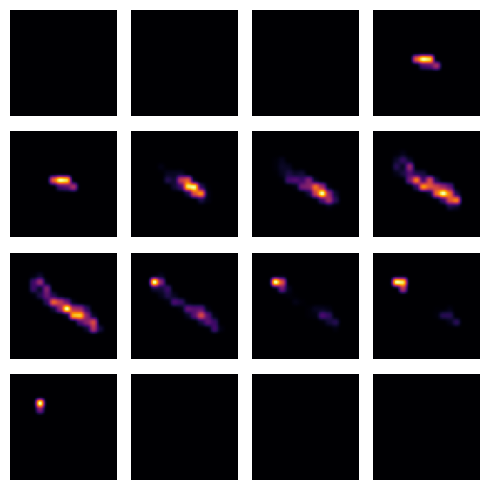

In [13]:
# Plot slices of the scalar field using matplotlib
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[5, 5])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(smoothed_scalar_field[img, :, :], 90), cmap='inferno')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

# Map texture onto mesh faces

In [14]:
# Map scalar values from the field onto the mesh vertices
vertex_coords = smoothed_mesh.vertices - 0.5
scalar_values_at_vertices = map_coordinates(smoothed_scalar_field, vertex_coords.T, order=1, mode='nearest')

In [15]:
# Calculate average scalar value per face of the mesh
average_scalar_per_face = scalar_values_at_vertices[smoothed_mesh.faces.astype("int")].mean(axis=1)

In [16]:
# Normalize and map the scalar values to colors for visualization
norm = mcolors.Normalize(vmin=average_scalar_per_face.min(), vmax=average_scalar_per_face.max())
colormap = plt.cm.plasma # Other options: https://matplotlib.org/stable/users/explain/colors/colormaps.html
colors = colormap(norm(average_scalar_per_face))

In [17]:
# Plot the colored mesh using meshplot
d = mp.subplot(smoothed_mesh.vertices, smoothed_mesh.faces.astype("int"), c=colors[:,0:3], s=[2, 2, 2])

# Export OBJ

In [18]:
# Assuming smoothed_mesh is your mesh and colors are your per-vertex colors
mesh = trimesh.Trimesh(vertices=smoothed_mesh.vertices, faces=smoothed_mesh.faces.astype("int"), face_colors=colors[:, :3])

# Attempt to make the mesh watertight and consistently orient the faces
mesh = mesh.process()

# Export to OBJ
result = trimesh.exchange.obj.export_obj(mesh, include_normals=None, include_color=True, include_texture=True, return_texture=False, write_texture=True, resolver=None, digits=8, mtl_name=None, header='https://github.com/mikedh/trimesh')

In [19]:
# Save the OBJ file
with open('output.obj', 'w') as f:
    f.write(result)